# Understanding ICL with saliency Demonstrations

# Contrastive Demonstrations & Saliency Maps
-----

## 0. Dependencies


In [1]:
# !pip install --upgrade pip
!pip install  transformers datasets captum
!pip install  scikit-learn numpy


## 1. Imports

In [2]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd

from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
)

from captum.attr import IntegratedGradients, Lime
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum._utils.models.linear_model import SkLearnLinearModel

from IPython.display import HTML, display
from collections import Counter
from collections import defaultdict


## 1.1 Setup
device selection depending on os

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


###  2. Load SST-2 and filter examples

Load SST-2 dataset and initialize the LLMs,
paper uses SST-2 and filters training examples to those with at least 20 tokens.

In [4]:
# The dataset the paper used : https://huggingface.co/datasets/stanfordnlp/sst2

# This code loads a dataset from the hugginface servers
sst2 = load_dataset("glue", "sst2")
train_data = sst2["train"]
val_data = sst2["validation"]

print("Total training examples:", len(train_data))
print("Total validation examples:", len(val_data))


def word_count(text: str) -> int:
    return len(text.split())

# filter to sentences with >= 20 tokens (approximate to the paper)
train_long = train_data.filter(lambda ex: word_count(ex["sentence"]) >= 20)
val_long = val_data.filter(lambda ex: word_count(ex["sentence"]) >= 20)

print("Long training examples (>=20 tokens):", len(train_long))
print("Long validation examples (>=20 tokens):", len(val_long))




# build test set from filtered validation data
test_data = list(val_long)

# optionally limit size for speed
MAX_TEST_SAMPLES = 250
if len(test_data) > MAX_TEST_SAMPLES:
    random.seed(42)
    test_data = random.sample(test_data, MAX_TEST_SAMPLES)


# We make sure that we have as many positives as negatives
positives = [ex for ex in test_data if ex["label"] == 1]
negatives = [ex for ex in test_data if ex["label"] == 0]

balanced_size = min(len(positives), len(negatives))
test_data = positives[:balanced_size] + negatives[:balanced_size]

print("Test set size:", len(test_data))
print("Example test sentence:", test_data[0]["sentence"], "| Label:", test_data[0]["label"])



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Total training examples: 67349
Total validation examples: 872


Filter:   0%|          | 0/67349 [00:00<?, ? examples/s]

Filter:   0%|          | 0/872 [00:00<?, ? examples/s]

Long training examples (>=20 tokens): 8294
Long validation examples (>=20 tokens): 415
Test set size: 238
Example test sentence: a densely constructed , highly referential film , and an audacious return to form that can comfortably sit among jean-luc godard 's finest work .  | Label: 1


## 3. Select 4 demonstration examples (2 positive, 2 negative)

We want 2 strongly positive and 2 strongly negative reviews as demonstrations, similar to the paper (distinct sentiment-indicative words).

In [5]:
positive_keywords = ["great", "excellent", "amazing", "fantastic", "wonderful", "best"]
negative_keywords = ["terrible", "awful", "horrible", "worst", "boring", "waste", "bad"]

pos_candidates = [
    ex for ex in train_long
    if ex["label"] == 1 and any(w in ex["sentence"].lower() for w in positive_keywords)
]
neg_candidates = [
    ex for ex in train_long
    if ex["label"] == 0 and any(w in ex["sentence"].lower() for w in negative_keywords)
]

print(f"Positive candidates: {len(pos_candidates)}")
print(f"Negative candidates: {len(neg_candidates)}")

# pick first two of each
assert len(pos_candidates) >= 2 and len(neg_candidates) >= 2, "Not enough candidates; try adjusting keywords."

demo_pos1 = pos_candidates[0]
demo_pos2 = pos_candidates[1]
demo_neg1 = neg_candidates[0]
demo_neg2 = neg_candidates[1]

print("Positive demo 1:", demo_pos1["sentence"])
print("Positive demo 2:", demo_pos2["sentence"])
print("Negative demo 1:", demo_neg1["sentence"])
print("Negative demo 2:", demo_neg2["sentence"])

Positive candidates: 341
Negative candidates: 332
Positive demo 1: bogdanovich puts history in perspective and , via kirsten dunst 's remarkable performance , he showcases davies as a young woman of great charm , generosity and diplomacy . 
Positive demo 2: is a greater attention to the parents -- and particularly the fateful fathers -- in the emotional evolution of the two bewitched adolescents . 
Negative demo 1: build some robots , haul 'em to the theater with you for the late show , and put on your own mystery science theatre 3000 tribute to what is almost certainly going to go down as the worst -- and only -- killer website movie of this or any other year 
Negative demo 2: was produced by jerry bruckheimer and directed by joel schumacher , and reflects the worst of their shallow styles : wildly overproduced , inadequately motivated every step of the way and demographically targeted to please every one ( and no one ) 


## 4. Build contrastive demonstrations

4 demos:

1. Original (correct label) and original language
2. Label-flipped
3. Input neutralized (adjectives toned down, label unchanged)
4. With explanations (label plus explanation line)

We’ll implement a simple neutralization (rule-based replacements).

In [6]:
demo_examples = [
    {"text": demo_pos1["sentence"], "label": "Positive"},
    {"text": demo_pos2["sentence"], "label": "Positive"},
    {"text": demo_neg1["sentence"], "label": "Negative"},
    {"text": demo_neg2["sentence"], "label": "Negative"},
]

def neutralize_text(text: str) -> str:
    # rule-based neutralization
    replacements = {
        # Stronger neutralization for positive adjectives/adverbs
        "great": "okay", "excellent": "acceptable", "amazing": "moderate",
        "fantastic": "average", "wonderful": "ordinary", "best": "common",
        "outstanding": "decent", "superb": "adequate", "perfect": "sufficient",
        "brilliant": "fine", "incredible": "average", "awesome": "moderate",
        "impressive": "okay", "remarkable": "decent", "enjoyable": "fine",
        "fabulous": "ordinary", "splendid": "acceptable", "marvelous": "average",
        "pleasant": "moderate", "delightful": "ordinary", "exceptional": "average",
        "terrific": "okay", "lovely": "fine", "phenomenal": "moderate",

        # Negative adjectives/adverbs (keep existing)
        "terrible": "very", "awful": "rather", "horrible": "really", "worst": "quite",
        "boring": "uneventful", "waste": "useful", "bad": "not good",
        "dreadful": "subpar", "lousy": "mediocre", "poor": "average",
        "unpleasant": "okay", "horrid": "acceptable", "mediocre": "decent",
        "annoying": "slightly irritating", "disappointing": "somewhat off",
        "frustrating": "challenging", "uninteresting": "neutral",
        "forgettable": "ordinary", "weak": "not strong", "substandard": "acceptable",
        "pathetic": "mediocre", "inferior": "average",

        # Intensifiers / adverbs
        "very": "slightly", "extremely": "moderately", "highly": "fairly",
        "so": "somewhat", "too": "a bit", "incredibly": "moderately",
        "exceptionally": "moderately", "really": "somewhat", "absolutely": "fairly",
        "completely": "somewhat", "totally": "moderately",

        # Common positive phrases
        "loved it": "liked it", "highly recommend": "recommend",
        "must watch": "worth watching", "top-notch": "average",
        "five stars": "three stars", "well done": "okay",
        "thumbs up": "neutral", "great job": "okay job",

        # Common negative phrases
        "hated it": "didn't like it", "do not recommend": "recommend cautiously",
        "waste of time": "not very engaging", "one star": "three stars",
        "poorly done": "okay effort", "could be better": "average",
    }



    result = text
    for w, n in replacements.items():
        result = result.replace(w, n)
        result = result.replace(w.capitalize(), n.capitalize())
    return result


# Falling short of being able to generate the context explanation using GPT4, and then refining those explanations manually for hundreds of examples,
# we will instead write a generic explanation for the positive and for the negative movie reviews that do no contain appreciative adjectives
explanations = []
for ex in demo_examples:
    if ex["label"] == "Positive":
        explanations.append("The review describes an experience where the viewer was able to follow and interpret the events in the film as they occurred.")
    else:
        explanations.append("The review describes an experience where the viewer encountered difficulties in following or interpreting some events in the film.")

original_demos = []
flipped_demos = []
neutral_demos = []
explained_demos = []

for i, ex in enumerate(demo_examples):
    text = ex["text"].strip()
    orig_label = ex["label"]
    flip_label = "Negative" if orig_label == "Positive" else "Positive"
    neut_text = neutralize_text(text)
    explanation = explanations[i]

    original_demos.append(f"Review: {text}\nSentiment: {orig_label}")
    flipped_demos.append(f"Review: {text}\nSentiment: {flip_label}")
    neutral_demos.append(f"Review: {neut_text}\nSentiment: {orig_label}")
    explained_demos.append(
        f"Review: {text}\nSentiment: {orig_label}\nExplanation: {explanation}"
    )

print("Original demo 1:\n", original_demos[0], "\n")
print("Flipped demo 1:\n", flipped_demos[0], "\n")
print("Neutralized demo 1:\n", neutral_demos[0], "\n")
print("Explanation demo 1:\n", explained_demos[0])


Original demo 1:
 Review: bogdanovich puts history in perspective and , via kirsten dunst 's remarkable performance , he showcases davies as a young woman of great charm , generosity and diplomacy .
Sentiment: Positive 

Flipped demo 1:
 Review: bogdanovich puts history in perspective and , via kirsten dunst 's remarkable performance , he showcases davies as a young woman of great charm , generosity and diplomacy .
Sentiment: Negative 

Neutralized demo 1:
 Review: bogdanovich puts history in perspective and , via kirsten dunst 's decent performance , he showcases davies as a young woman of okay charm , generosity and diplomacy .
Sentiment: Positive 

Explanation demo 1:
 Review: bogdanovich puts history in perspective and , via kirsten dunst 's remarkable performance , he showcases davies as a young woman of great charm , generosity and diplomacy .
Sentiment: Positive
Explanation: The review describes an experience where the viewer was able to follow and interpret the events in the fi

## 5. Prompt builder for in-context learning

We put 4 demos then the test review, and leave Sentiment: blank for GPT-2 to complete.

In [7]:
def build_prompt(demo_list, test_sentence: str) -> str:
    prompt = ""
    for demo in demo_list:
        prompt += demo.strip() + "\n\n"
    prompt += f"Review: {test_sentence.strip()}\nSentiment: "
    return prompt

# prompt examples
sample_prompt = build_prompt(original_demos, test_data[0]["sentence"])
print(sample_prompt)

print("\n\n\n")
sample_prompt = build_prompt(explained_demos, test_data[0]["sentence"])
print(sample_prompt)


Review: bogdanovich puts history in perspective and , via kirsten dunst 's remarkable performance , he showcases davies as a young woman of great charm , generosity and diplomacy .
Sentiment: Positive

Review: is a greater attention to the parents -- and particularly the fateful fathers -- in the emotional evolution of the two bewitched adolescents .
Sentiment: Positive

Review: build some robots , haul 'em to the theater with you for the late show , and put on your own mystery science theatre 3000 tribute to what is almost certainly going to go down as the worst -- and only -- killer website movie of this or any other year
Sentiment: Negative

Review: was produced by jerry bruckheimer and directed by joel schumacher , and reflects the worst of their shallow styles : wildly overproduced , inadequately motivated every step of the way and demographically targeted to please every one ( and no one )
Sentiment: Negative

Review: a densely constructed , highly referential film , and an audac

## 6. Load GPT-2 & implement ICL prediction

We’ll decode the next token and interpret it as “Positive”/“Negative”.

In [8]:
# Load GPT-2
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

gpt2_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
gpt2_model.eval()


# -----------------------------------------------------------
# Clean parser: extract "Positive" or "Negative" from a text
# -----------------------------------------------------------
def extract_label(text: str) -> str:
    t = text.strip().lower()

    # strict matching
    if t == "positive":
        return "Positive"
    if t == "negative":
        return "Negative"

    # looser matching if output has extra tokens
    if "positive" in t:
        return "Positive"
    if "negative" in t:
        return "Negative"

    return "Negative"   # fallback


# -----------------------------------------------------------
# GPT-2 sentiment classifier via generation
# -----------------------------------------------------------
def predict_gpt2_sentiment(prompt: str) -> str:
    """Force GPT-2 to *generate* a label and then parse it."""

    inputs = gpt2_tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        generated = gpt2_model.generate(
            **inputs,
            max_new_tokens=3,          # enough to get "Positive" or "Negative"
            do_sample=False,           # deterministic
            pad_token_id=gpt2_tokenizer.eos_token_id
        )

    full_text = gpt2_tokenizer.decode(generated[0])

    # Get only what GPT-2 produced *after* the prompt
    completion = full_text[len(prompt):].strip()

    return extract_label(completion)


# Quick test
test_prompt = (
    "Review: I really loved this movie. It was exciting and beautiful.\n"
    "Sentiment (Positive/Negative): "
)

print("GPT-2 test prediction:", predict_gpt2_sentiment(test_prompt))


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT-2 test prediction: Negative


## 7. Evaluate GPT-2 under the four demo conditions

We’ll compute accuracy for:

- Original demos

- Label-flipped demos

- Neutralized input demos

- Explanation demos

In [11]:
label_map = {"Positive": 1, "Negative": 0}
conditions = ["Original", "Label-Flipped", "Neutralized", "With-Explanation", "No-ICL"]

# Initialize structures
correct_counts = {c: 0 for c in conditions}
all_preds = {c: [] for c in conditions}   # store predicted labels
all_trues = []                            # store true labels

for ex in test_data:
    true_label = ex["label"]
    sent = ex["sentence"]

    all_trues.append(true_label)

    prompts = {
        "Original": build_prompt(original_demos, sent),
        "Label-Flipped": build_prompt(flipped_demos, sent),
        "Neutralized": build_prompt(neutral_demos, sent),
        "With-Explanation": build_prompt(explained_demos, sent),
        "No-ICL": f"You are GPT2, you are classifying a review's sentiment. It is either \"Positive\" or \"Negative\".\n Review: \"{sent}\"\nSentiment:"
    }# without examples, the prompt becomes very important

    for cond, prompt in prompts.items():
        pred_text = predict_gpt2_sentiment(prompt)

        if pred_text not in label_map:
            print(f"Unexpected prediction for condition '{cond}': {repr(pred_text)}")
            # You can still assign a default or skip counting
            pred_label = None
        else:
            pred_label = label_map[pred_text]  # safe now
            all_preds[cond].append(pred_label)

            if pred_label == true_label:
                correct_counts[cond] += 1


# Print basic results
print("\nCorrect counts:", correct_counts)

accuracy = {cond: correct_counts[cond] / len(test_data) for cond in conditions}
print("\nGPT-2 accuracy:")
for cond, acc in accuracy.items():
    print(f"{cond}: {acc*100:.2f}%")



Correct counts: {'Original': 168, 'Label-Flipped': 143, 'Neutralized': 177, 'With-Explanation': 172, 'No-ICL': 121}

GPT-2 accuracy:
Original: 70.59%
Label-Flipped: 60.08%
Neutralized: 74.37%
With-Explanation: 72.27%
No-ICL: 50.84%


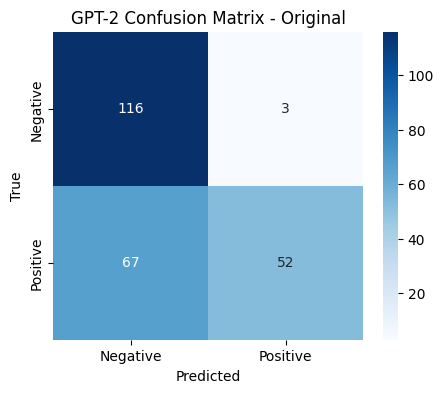

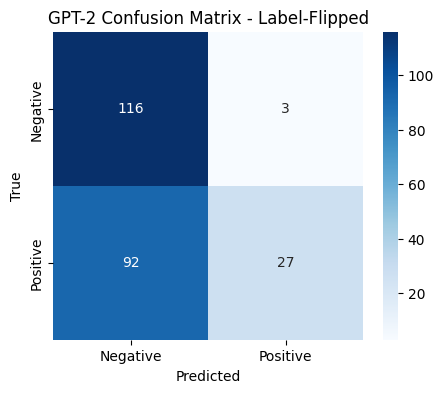

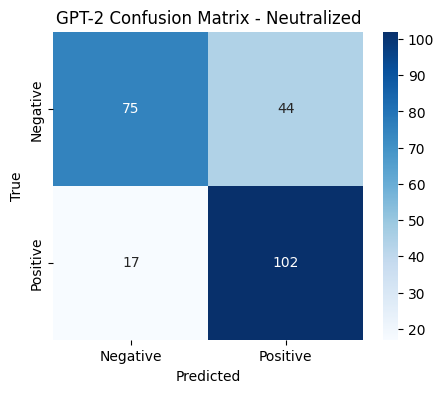

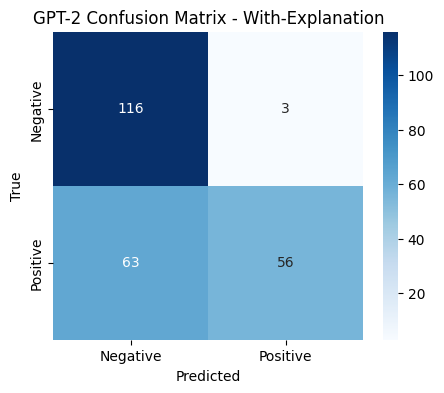

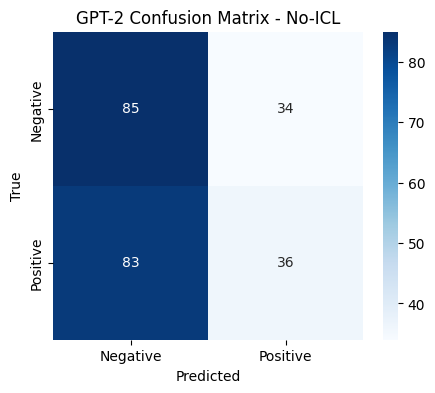

In [12]:
# Our neutralization method doesn't seem to have the same effect the paper had.
# Let's investigate why it could be by making confusion matricies

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for cond in conditions:
    cm = confusion_matrix(all_trues, all_preds[cond])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"GPT-2 Confusion Matrix - {cond}")
    plt.show()

##Analysis of the confusion matrices
As we can see, the Input neutralization skewed the model towards predicting a "Positive" label more often regardless of ground truth.
This effect hints at the model's original bias that mostly classifies reviews as "Negative", and at the fact that our neutralization method fails to capture the subtle details in which a review can be positive.
We therefore fail at replicating the findings of the paper.

##Summary :
We successfully showed that for a small model, label flipping has a detrimental effect on the predictions accuracy, and that CE has a minimal effect (even if its design is not review specific).

##What's next in this demonstration
Because of resource restrictions, we won't be able to make the comparisons between the small and bigger models, so we will continue the analysis of the ICL by using the saliency maps, and seeing how the model distributes its attention.

 ## 8. BERT baseline: supervised DistilBERT on SST-2

We’ll use Hugging Face’s pre-fine-tuned SST-2 DistilBERT as an example of what a model of this size could achieve without ICL and just fine-tuning

In [13]:
bert_classifier = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    return_all_scores=True,
)

bert_correct = 0
for ex in test_data:
    text = ex["sentence"]
    true_label = ex["label"]
    scores = bert_classifier(text)[0]
    # scores is list of [{'label': 'NEGATIVE', 'score': ...}, {'label': 'POSITIVE', 'score': ...}]
    best = max(scores, key=lambda x: x["score"])
    pred = 1 if best["label"].upper() == "POSITIVE" else 0
    if pred == true_label:
        bert_correct += 1

bert_acc = bert_correct / len(test_data)
print(f"DistilBERT fine-tuned accuracy: {bert_acc*100:.2f}%")


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


DistilBERT fine-tuned accuracy: 91.18%


## 9. Accuracy table

In [14]:
acc_df = pd.DataFrame(
    {
        "Model / Condition": [
            "GPT-2 With ICL",
            "GPT-2 Label-Flipped",
            "GPT-2 Neutralized",
            "GPT-2 + Explanation",
            "GPT-2 Without ICL",
            "BERT fine-tuned",
        ],
        "Accuracy (%)": [
            accuracy["Original"] * 100,
            accuracy["Label-Flipped"] * 100,
            accuracy["Neutralized"] * 100,
            accuracy["With-Explanation"] * 100,
            accuracy["No-ICL"] * 100,
            bert_acc * 100,
        ],
    }
)
acc_df.style.format({"Accuracy (%)": "{:.2f}"})


,Model / Condition,Accuracy (%)
0,GPT-2 With ICL,70.59
1,GPT-2 Label-Flipped,60.08
2,GPT-2 Neutralized,74.37
3,GPT-2 + Explanation,72.27
4,GPT-2 Without ICL,50.84
5,BERT fine-tuned,91.18


## 10. Captum: Integrated Gradients for GPT-2 prompts

We now compute IG for one example across all four demo conditions.

### 10.1. Picking an example GPT-2 understands correctly

In [15]:
example_index = None
for idx, ex in enumerate(test_data):
    prompt = build_prompt(original_demos, ex["sentence"])
    pred = predict_gpt2_sentiment(prompt)
    true_label = "Positive" if ex["label"] == 1 else "Negative"
    if pred == true_label:
        example_index = idx
        break

if example_index is None:
    example_index = 0

example = test_data[example_index]
print("Selected example index:", example_index)
print("Sentence:", example["sentence"])
print("Label:", example["label"])


Selected example index: 0
Sentence: a densely constructed , highly referential film , and an audacious return to form that can comfortably sit among jean-luc godard 's finest work . 
Label: 1


### 10.2. Define GPT-2 forward function for Captum

We’ll attribute the probability of the next token being " Positive".

In [16]:
# token ids for "Positive"
pos_ids = gpt2_tokenizer.encode(" Positive", add_special_tokens=False)
positive_id = pos_ids[0]
positive_id



def gpt2_forward_for_ig(inputs_embeds: torch.Tensor, attention_mask: torch.Tensor = None):

    outputs = gpt2_model(
        inputs_embeds=inputs_embeds.to(device),
        attention_mask=attention_mask.to(device) if attention_mask is not None else None,
    )
    logits = outputs.logits[:, -1, :]   # (batch, vocab_size)
    probs = F.softmax(logits, dim=-1)
    pos_prob = probs[:, positive_id]    # (batch,)
    return pos_prob



ig = IntegratedGradients(gpt2_forward_for_ig)


### 10.3. Helper to run IG on a prompt

In [17]:
def encode_for_ig(prompt: str):
    enc = gpt2_tokenizer(prompt, return_tensors="pt")
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device).long()
    inputs_embeds = gpt2_model.transformer.wte(input_ids)
    return input_ids, inputs_embeds, attention_mask

def ig_attribution_for_prompt(prompt: str, n_steps: int = 50):
    input_ids, inputs_embeds, attention_mask = encode_for_ig(prompt)
    baseline_ids = torch.full_like(input_ids, gpt2_tokenizer.eos_token_id, dtype=torch.long, device=device)
    baseline_embeds = gpt2_model.transformer.wte(baseline_ids)

    attributions = ig.attribute(
        inputs=inputs_embeds,
        baselines=baseline_embeds,
        additional_forward_args=(attention_mask,),
        n_steps=n_steps,
        internal_batch_size=1,
    )  # (1, seq_len, hidden)

    token_attrib = attributions.sum(dim=-1)  # sum over embedding dims -> (1, seq_len)
    tokens = gpt2_tokenizer.convert_ids_to_tokens(input_ids[0])
    scores = token_attrib[0].detach().cpu().numpy()

    abs_scores = np.abs(scores)
    maxval = abs_scores.max() if abs_scores.max() != 0 else 1.0
    norm_scores = abs_scores / maxval
    return tokens, norm_scores


### 10.4. Compute IG for all four demo conditions

In [18]:
ex_sentence = example["sentence"]

prompts = {
    "Original": build_prompt(original_demos, ex_sentence),
    "Label-Flipped": build_prompt(flipped_demos, ex_sentence),
    "Neutralized": build_prompt(neutral_demos, ex_sentence),
    "Explanation": build_prompt(explained_demos, ex_sentence),
}

ig_results = {}
for cond, p in prompts.items():
    print(f"Computing IG for condition: {cond}")
    tokens, scores = ig_attribution_for_prompt(p)
    ig_results[cond] = (tokens, scores)
    print("Prediction:", predict_gpt2_sentiment(p))


Computing IG for condition: Original
Prediction: Positive
Computing IG for condition: Label-Flipped
Prediction: Negative
Computing IG for condition: Neutralized
Prediction: Positive
Computing IG for condition: Explanation
Prediction: Positive


### 10.5. HTML visualization of token saliency

In [22]:
# Visualization function
def highlight_tokens(tokens, scores):
    spans = []
    for tok, s in zip(tokens, scores):
        if tok == gpt2_tokenizer.eos_token:
            continue
        s = max(0.0, min(1.0, s))
        opacity = 0.05 + 0.9 * s
        color = f"rgba(255, 0, 0, {opacity:.2f})"
        safe_tok = tok.replace("<", "&#266;").replace(">", "&gt;")
        if safe_tok.startswith(("Ġ", "Ċ")):
            safe_tok = safe_tok[1:]
            spans.append(" ")
        spans.append(
            f"<span style='background-color:{color}; color:black; padding:2px 3px; border-radius:3px; margin:0 1px; font-weight:500;'>{safe_tok}</span>"
        )
    return "".join(spans)

#to identify CE tokens
all_explanations = [
    "The review describes an experience where the viewer was able to follow and interpret the events in the film as they occurred.",
    "The review describes an experience where the viewer encountered difficulties in following or interpreting some events in the film."
]

def get_label_ce_tokens(tokens, condition):
    label_tokens = []
    ce_tokens = []

    # Normalize tokens
    token_texts = [tok.replace("Ġ","").replace("Ċ","").lower() for tok in tokens]

    # Labels
    for i, tok in enumerate(token_texts):
        if tok in ["positive", "negative"]:
            label_tokens.append(i)

    # CE tokens (condition name *must* match your dictionary)
    if condition.lower() in ["explanation", "with-explanation"]:
        for ce_sentence in all_explanations:
            # tokenize CE sentence using GPT-2 tokenizer (critical!)
            ce_tokens_raw = gpt2_tokenizer.tokenize(ce_sentence)

            # Clean same as token_texts
            ce_tokens_clean = [
                t.replace("Ġ","").replace("Ċ","").lower()
                for t in ce_tokens_raw
            ]

            L = len(ce_tokens_clean)

            # sliding window over model input tokens
            for i in range(len(token_texts) - L + 1):
                if token_texts[i:i+L] == ce_tokens_clean:
                    ce_tokens.extend(range(i, i+L))

    return label_tokens, ce_tokens

# Identify neutralized words by diffing Original vs Neutralized tokens
def get_neutralized_indices(orig_tokens, neut_tokens):
    # Simplest approach: mark tokens that are different at the same position
    min_len = min(len(orig_tokens), len(neut_tokens))
    neutralized_indices = []
    for i in range(min_len):
        if orig_tokens[i] != neut_tokens[i]:
            neutralized_indices.append(i)
    return neutralized_indices

# Compute saliency tables
saliency_summary = {}
percent_summary = {}
neutralized_saliency_comparison = {}

for cond, (tokens, scores) in ig_results.items():
    html_str = highlight_tokens(tokens, scores)
    display(HTML(f"""
        <div style='background-color:#f5f5f5; padding:15px; border-radius:5px; margin-bottom:20px;'>
            <h3 style='color:#333; margin-top:0;'>{cond} prompt (IG saliency)</h3>
            <div style='line-height:1.8em; font-size:14px;'>{html_str}</div>
        </div>
    """))

    label_tokens, ce_tokens = get_label_ce_tokens(tokens, cond)
    neutralized_tokens = []

    # for "Neutralized" find words changed from Original
    if cond == "Neutralized":
        orig_tokens = ig_results["Original"][0]
        neutralized_tokens = get_neutralized_indices(orig_tokens, tokens)

        # Compare saliency for these words in Original vs Neutralized maps
        orig_scores = ig_results["Original"][1]
        neutralized_saliency_comparison[cond] = {
            "Original avg": sum(orig_scores[i] for i in neutralized_tokens)/len(neutralized_tokens) if neutralized_tokens else 0.0,
            "Neutralized avg": sum(scores[i] for i in neutralized_tokens)/len(neutralized_tokens) if neutralized_tokens else 0.0
        }

    # Average saliency per group
    saliency_summary[cond] = {
        "Label tokens": sum(scores[i] for i in label_tokens)/len(label_tokens) if label_tokens else 0.0,
        "CE tokens": sum(scores[i] for i in ce_tokens)/len(ce_tokens) if ce_tokens else 0.0,
        "Neutralized tokens": sum(scores[i] for i in neutralized_tokens)/len(neutralized_tokens) if neutralized_tokens else 0.0
    }

    total_score = sum(scores)
    percent_summary[cond] = {
        "Label %": sum(scores[i] for i in label_tokens)/total_score*100 if total_score else 0.0,
        "CE %": sum(scores[i] for i in ce_tokens)/total_score*100 if total_score else 0.0,
        "Neutralized %": sum(scores[i] for i in neutralized_tokens)/total_score*100 if total_score else 0.0
    }


df_avg = pd.DataFrame(saliency_summary).T
df_percent = pd.DataFrame(percent_summary).T
df_neutralized = pd.DataFrame(neutralized_saliency_comparison).T

print("Average IG saliency per token group:")
display(df_avg)

print("IG saliency as % of total score:")
display(df_percent)

print("Neutralized words saliency comparison (Original vs Neutralized):")
display(df_neutralized)


### PLEASE BE CAREFUL TO SCROLL ALL THE WAY DOWN TO SEE THE RESULTS

Average IG saliency per token group:


,Label tokens,CE tokens,Neutralized tokens
Original,0.067504,0.000000,0.000000
Label-Flipped,0.121717,0.000000,0.000000
Neutralized,0.072871,0.000000,0.029712
Explanation,0.058519,0.018551,0.000000


IG saliency as % of total score:


,Label %,CE %,Neutralized %
Original,3.004746,0.000000,0.000000
Label-Flipped,5.512565,0.000000,0.000000
Neutralized,3.101744,0.000000,61.020923
Explanation,2.268307,15.460526,0.000000


Neutralized words saliency comparison (Original vs Neutralized):


,Original avg,Neutralized avg
Neutralized,0.04004,0.029712


## 11. Captum LIME for BERT classifier

Now use Captum LIME on DistilBERT to get perturbation-based saliency for the same example.

### 11.1. Load BERT model + tokenizer for Captum

We’ll load the same model that the pipeline used, but as AutoModelForSequenceClassification.

In [23]:
bert_model_name = "distilbert-base-uncased-finetuned-sst-2-english"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_name).to(device)
bert_model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### 11.2. Forward function for Captum (returns logits)

In [24]:
def bert_forward_token_ids(input_ids: torch.Tensor, attention_mask: torch.Tensor = None):

    outputs = bert_model(
        input_ids=input_ids.to(device),
        attention_mask=attention_mask.to(device) if attention_mask is not None else None,
    )
    return outputs.logits


### 11.3. Prepare inputs & feature mask for the chosen example

In [25]:
test_text = example["sentence"]
true_label_name = "Positive" if example["label"] == 1 else "Negative"

print("LIME example text:", test_text)
print("True label:", true_label_name)


encoded = bert_tokenizer(test_text, return_tensors="pt")
input_ids_bert = encoded["input_ids"].to(device)
attention_mask_bert = encoded["attention_mask"].to(device)

seq_len = input_ids_bert.size(1)
feature_mask = torch.arange(seq_len).unsqueeze(0).to(device)  # each token index is its own feature

tokens_bert = bert_tokenizer.convert_ids_to_tokens(input_ids_bert[0])
tokens_bert


LIME example text: a densely constructed , highly referential film , and an audacious return to form that can comfortably sit among jean-luc godard 's finest work . 
True label: Positive


['[CLS]',
 'a',
 'densely',
 'constructed',
 ',',
 'highly',
 'refer',
 '##ential',
 'film',
 ',',
 'and',
 'an',
 'au',
 '##da',
 '##cious',
 'return',
 'to',
 'form',
 'that',
 'can',
 'comfortably',
 'sit',
 'among',
 'jean',
 '-',
 'luc',
 'god',
 '##ard',
 "'",
 's',
 'finest',
 'work',
 '.',
 '[SEP]']

### 11.4. Instantiate Captum LIME

In [26]:
# Captum LIME -_> scikit-learn for the surrogate linear model
#try:
#    import sklearn  # noqa: F401
#except ImportError:
#    raise ImportError("scikit-learn for LIME; not present!!!!.")


similarity_func = get_exp_kernel_similarity_function()
interpretable_model = SkLearnLinearModel("linear_model.LinearRegression")

lime = Lime(
    forward_func=bert_forward_token_ids,
    interpretable_model=interpretable_model,
    similarity_func=similarity_func,
)



### 11.5. Compute LIME attributions

Target class = 1 (Positive). You can also try 0 (Negative).

In [27]:
target_class = 1  # Positive

attr_lime = lime.attribute(
    inputs=input_ids_bert,
    additional_forward_args=(attention_mask_bert,),
    target=target_class,
    feature_mask=feature_mask,
    n_samples=100,             # number of perturbations
    perturbations_per_eval=10  # batch
)  # shape: (1, seq_len)

attr_lime.shape


lime_scores = attr_lime[0].detach().cpu().numpy()
abs_scores = np.abs(lime_scores)
maxval = abs_scores.max() if abs_scores.max() != 0 else 1.0
norm_lime = abs_scores / maxval


### 11.6. Visualize LIME tokens (simple intensity)

You can either use sign (positive/negative) or just magnitude. Here we’ll color positive contributions green, negative red.

In [28]:
def highlight_tokens_lime(tokens, scores, raw_scores):

    spans = []
    for tok, mag, val in zip(tokens, scores, raw_scores):
        # skip special tokens
        if tok in ["[CLS]", "[SEP]", "[PAD]"]:
            continue
        if mag == 0:
            spans.append(tok.replace("##", ""))  # no highlight
            spans.append(" ")
            continue

        # color: green for positive, red for negative
        if val >= 0:
            color = f"rgba(0, 255, 0, {mag})"
        else:
            color = f"rgba(255, 0, 0, {mag})"

        clean_tok = tok.replace("##", "")  # join subwords
        spans.append(f"<span style='background-color:{color}'>{clean_tok}</span>")
        spans.append(" ")

    return "".join(spans)

html_lime = highlight_tokens_lime(tokens_bert, norm_lime, lime_scores)
display(HTML(f"<h3>LIME explanation for BERT (target=Positive)</h3><div style='line-height:1.6em'>{html_lime}</div>"))


## 12. Testing Larger Models: e.g Qwen2.5-0.5B

Prior examples can be easily reproduced on most local devices; however, LLMs are typically larger. The techniques discussed in the paper were tested on various model sizes. This section will demonstrate an example using **Qwen2.5-1.5B**."

### Key Considerations for Larger Models:

1. **Memory Requirements**: Larger models require more VRAM. Qwen2.5-1.5B needs ~8GB in fp16.
2. **Tokenizer Differences**: Each model family has its own tokenizer with different special tokens.
3. **Inference Speed**: Larger models are slower, affecting the time needed for attribution methods.

### 12.1 Loading Qwen2.5-1.5B

**Note**: The code below should NOT be executed if you don't have sufficient GPU resources if you want to read the trace first.

In [48]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load Qwen2.5-1.5B model and tokenizer
qwen_model_name = "Qwen/Qwen2.5-1.5B"

qwen_tokenizer = AutoTokenizer.from_pretrained(qwen_model_name)
qwen_model = AutoModelForCausalLM.from_pretrained(
    qwen_model_name,
    torch_dtype=torch.float16,  # Use fp16 to reduce memory
    device_map="auto"           # Automatically distribute across available devices
)
qwen_model.eval()

print(f"Model loaded: {qwen_model_name}")
print(f"Number of parameters: {qwen_model.num_parameters() / 1e9:.2f}B")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Model loaded: Qwen/Qwen2.5-1.5B
Number of parameters: 1.54B


### 12.2. Token Inference with Qwen2.5

Unlike the simple next-token prediction used with GPT-2, larger models benefit from proper generation
methods with sampling, temperature control, and stopping criteria.

#### Documentation References:

- **Hugging Face Generation Docs**: https://huggingface.co/docs/transformers/main/en/main_classes/text_generation
- **Qwen2.5 Model Card**: https://huggingface.co/Qwen/Qwen2.5-0.5B-Instruct
- **Generation Parameters**: https://huggingface.co/docs/transformers/main/en/generation_strategies

Qwen2.5 test prediction should be positive: Positive

Qwen correct counts: {'Original': 212, 'Label-Flipped': 211, 'Neutralized': 207, 'With-Explanation': 179, 'No-ICL': 198}

Qwen2.5 accuracy:
Original: 89.08%
Label-Flipped: 88.66%
Neutralized: 86.97%
With-Explanation: 75.21%
No-ICL: 83.19%


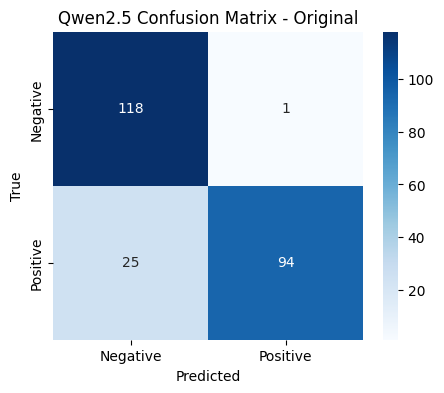

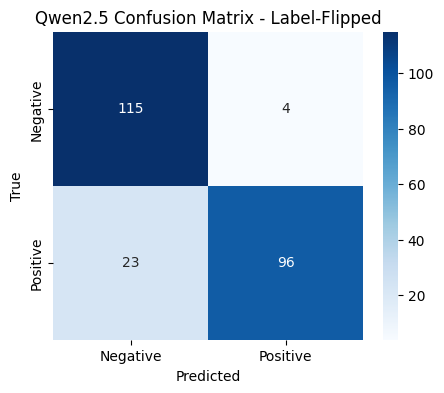

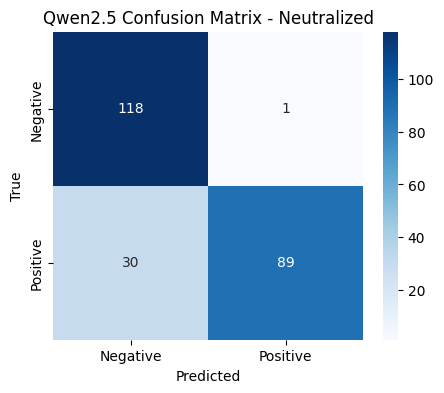

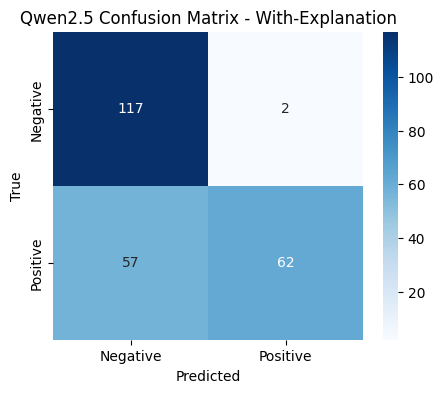

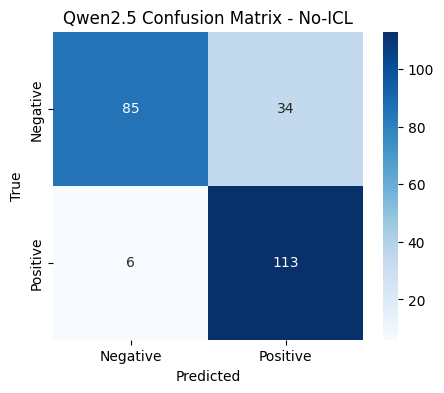

In [51]:
def predict_qwen_sentiment(prompt: str, max_new_tokens: int = 5) -> str:
    """
    Make Qwen generate a short label and parse it.
    Mirrors the GPT-2 version but using Qwen's tokenizer/model.
    """

    # Tokenize input
    inputs = qwen_tokenizer(prompt, return_tensors="pt").to(qwen_model.device)

    # Generate label
    with torch.no_grad():
        outputs = qwen_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=qwen_tokenizer.eos_token_id
        )

    # Decode only new text
    input_len = inputs["input_ids"].shape[1]
    new_tokens = outputs[0][input_len:]
    completion = qwen_tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

    return extract_label(completion)


# Quick sanity test
test_prompt = (
    "Review: I really loved this movie. It was exciting and beautiful.\n"
    "Sentiment (choose Positive or Negative): "
)
print("Qwen2.5 test prediction should be positive:", predict_qwen_sentiment(test_prompt))

label_map = {"Positive": 1, "Negative": 0}
conditions = ["Original", "Label-Flipped", "Neutralized", "With-Explanation", "No-ICL"]

# We need to make a different prompt for Qwen because it needs reminder of who it is
def build_prompt_qwen(demo_list, test_sentence: str) -> str:
    prompt ="You are Qwen, classifying a review's sentiment. It is either \"Positive\" or \"Negative\". Here are correct examples:\n"
    for demo in demo_list:
        prompt += demo.strip() + "\n\n"
    prompt += f"Review: {test_sentence.strip()}\nSentiment: "
    return prompt


correct_counts_qwen = {c: 0 for c in conditions}
all_preds_qwen = {c: [] for c in conditions}
all_trues_qwen = []

for ex in test_data:
    true_label = ex["label"]
    sent = ex["sentence"]

    all_trues_qwen.append(true_label)

    # EXACT same 5 prompt conditions as GPT-2
    prompts = {
        "Original":        build_prompt_qwen(original_demos, sent),
        "Label-Flipped":   build_prompt_qwen(flipped_demos, sent),
        "Neutralized":     build_prompt_qwen(neutral_demos, sent),
        "With-Explanation": build_prompt_qwen(explained_demos, sent),
        "No-ICL": (
            "You are Qwen, classifying a review's sentiment. "
            "It is either \"Positive\" or \"Negative\".\n"
            f"Review: \"{sent}\"\nSentiment: "
        )
    }

    for cond, prompt in prompts.items():

        pred_text = predict_qwen_sentiment(prompt)

        if pred_text not in label_map:
            print(f"[Qwen] Unexpected prediction in '{cond}': {repr(pred_text)}")
            pred_label = None
        else:
            pred_label = label_map[pred_text]
            all_preds_qwen[cond].append(pred_label)

            if pred_label == true_label:
                correct_counts_qwen[cond] += 1

print("\nQwen correct counts:", correct_counts_qwen)

accuracy_qwen = {
    cond: correct_counts_qwen[cond] / len(test_data)
    for cond in conditions
}

print("\nQwen2.5 accuracy:")
for cond, acc in accuracy_qwen.items():
    print(f"{cond}: {acc*100:.2f}%")


for cond in conditions:
    cm = confusion_matrix(all_trues_qwen, all_preds_qwen[cond])

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Negative","Positive"],
        yticklabels=["Negative","Positive"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Qwen2.5 Confusion Matrix - {cond}")
    plt.show()


### 12.3. Adapting Integrated Gradients for Qwen2.5

The IG implementation needs modifications for larger models:

1. **Different embedding layer**: Qwen uses `model.model.embed_tokens` instead of `model.transformer.wte`
2. **Memory optimization**: Use gradient checkpointing and reduced batch sizes
3. **Target token selection**: Identify the correct token IDs for "Positive"/"Negative"

In [34]:
# Uncomment to use Integrated Gradients with Qwen2.5

from captum.attr import IntegratedGradients
import torch.nn.functional as F

# Get token IDs for sentiment labels
positive_tokens = qwen_tokenizer.encode(" Positive", add_special_tokens=False)
negative_tokens = qwen_tokenizer.encode(" Negative", add_special_tokens=False)
print(f"Positive token ID(s): {positive_tokens}")
print(f"Negative token ID(s): {negative_tokens}")

# Use the first token ID for attribution
positive_id = positive_tokens[0]



def qwen_forward_for_ig(inputs_embeds: torch.Tensor, attention_mask: torch.Tensor = None):

    outputs = qwen_model(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask
    )

    # Get logits for the last position (next token prediction)
    logits = outputs.logits[:, -1, :]  # (batch_size, vocab_size)
    probs = F.softmax(logits, dim=-1)

    # Return probability of positive token
    return probs[:, positive_id]



def encode_for_ig_qwen(prompt: str):

    enc = qwen_tokenizer(prompt, return_tensors="pt")
    input_ids = enc["input_ids"].to(qwen_model.device)
    attention_mask = enc["attention_mask"].to(qwen_model.device)

    # Get embeddings - Qwen uses model.model.embed_tokens
    inputs_embeds = qwen_model.model.embed_tokens(input_ids)

    return input_ids, inputs_embeds, attention_mask



def ig_attribution_qwen(prompt: str, n_steps: int = 20):

    input_ids, inputs_embeds, attention_mask = encode_for_ig_qwen(prompt)

    # Create baseline (padding token)
    baseline_ids = torch.full_like(input_ids, qwen_tokenizer.pad_token_id)
    baseline_embeds = qwen_model.model.embed_tokens(baseline_ids)

    # Initialize IG
    ig = IntegratedGradients(qwen_forward_for_ig)

    # Compute attributions
    with torch.no_grad():
        attr = ig.attribute(
            inputs=inputs_embeds,
            baselines=baseline_embeds,
            additional_forward_args=(attention_mask,),
            n_steps=n_steps,
            internal_batch_size=1  # Reduce memory usage
        )

    # Sum over embedding dimension
    attr_sum = attr.sum(dim=-1).squeeze(0).detach().cpu().numpy()

    # Normalize scores
    abs_attr = np.abs(attr_sum)
    max_val = abs_attr.max() if abs_attr.max() != 0 else 1.0
    scores = abs_attr / max_val

    # Get tokens
    tokens = [qwen_tokenizer.decode([tid]) for tid in input_ids[0]]

    return tokens, scores

# Example usage:
test_prompt = build_prompt(original_demos, test_data[0]["sentence"])
tokens, scores = ig_attribution_qwen(test_prompt)
html_str = highlight_tokens(tokens, scores)
display(HTML(f"""
    <div style='background-color:#f5f5f5; padding:15px; border-radius:5px; margin-bottom:20px;'>
        <h3 style='color:#333; margin-top:0;'>(Example prompt saliency)</h3>
        <div style='line-height:1.8em; font-size:14px;'>{html_str}</div>
    </div>
"""))

Positive token ID(s): [43903]
Negative token ID(s): [50857]


### 12.4. fit LIME for Qwen2.5

LIME can be adapted similarly, but works directly with token IDs rather than embeddings.

In [38]:
# Uncomment to use LIME with Qwen2.5 (for classification tasks)

from captum.attr import Lime
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum._utils.models.linear_model import SkLearnLinearModel

# Note: LIME is typically used with classification models that output class probabilities.
# For causal LMs like Qwen2.5, you may need to adapt the forward function to return
# classification scores for your task.


def qwen_forward_for_lime(input_ids: torch.Tensor, attention_mask: torch.Tensor = None):

    outputs = qwen_model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    # Get logits for last position
    logits = outputs.logits[:, -1, :]

    # Return logits for positive and negative tokens only
    # This simulates a binary classification output
    sentiment_logits = torch.stack([
        logits[:, negative_tokens[0]],
        logits[:, positive_tokens[0]]
    ], dim=1)

    return sentiment_logits

# Initialize LIME
similarity_func = get_exp_kernel_similarity_function()
interpretable_model = SkLearnLinearModel("linear_model.LinearRegression")

lime_qwen = Lime(
    forward_func=qwen_forward_for_lime,
    interpretable_model=interpretable_model,
    similarity_func=similarity_func,
)

# Example usage:
test_text = test_data[0]["sentence"]
encoded = qwen_tokenizer(test_text, return_tensors="pt")
input_ids = encoded["input_ids"].to(qwen_model.device)
attention_mask = encoded["attention_mask"].to(qwen_model.device)

seq_len = input_ids.size(1)
feature_mask = torch.arange(seq_len).unsqueeze(0).to(qwen_model.device)

attr_lime = lime_qwen.attribute(
    inputs=input_ids,
    additional_forward_args=(attention_mask,),
    target=1,  # Positive class
    feature_mask=feature_mask,
    n_samples=50,  # Reduced for speed
    perturbations_per_eval=5
)

attr_lime.shape

lime_scores = attr_lime[0].detach().cpu().numpy()
abs_scores = np.abs(lime_scores)
maxval = abs_scores.max() if abs_scores.max() != 0 else 1.0
norm_lime = abs_scores / maxval

html_lime = highlight_tokens_lime(tokens, norm_lime, lime_scores)
display(HTML(f"<h3>LIME explanation for GWEN (target=Positive)</h3><div style='line-height:1.6em'>{html_lime}</div>"))

### Useful Documentation:

- **Qwen2.5 Documentation**: https://qwen.readthedocs.io/
- **Hugging Face Text Generation**: https://huggingface.co/docs/transformers/main/en/main_classes/text_generation
- **Captum Tutorials**: https://captum.ai/tutorials/
- **Memory Optimization**: https://huggingface.co/docs/transformers/main/en/performance